/tmp/ipykernel_49861/4265103159.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.data = pd.read_csv(filename, delim_whitespace=True)
/tmp/ipykernel_49861/4265103159.py:125: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data1 = pd.read_csv(datafile, delim_whitespace=True)


VSB = 3.0 V → kappa = 0.8010202467720436, I0 = 7.915036210944284e-25


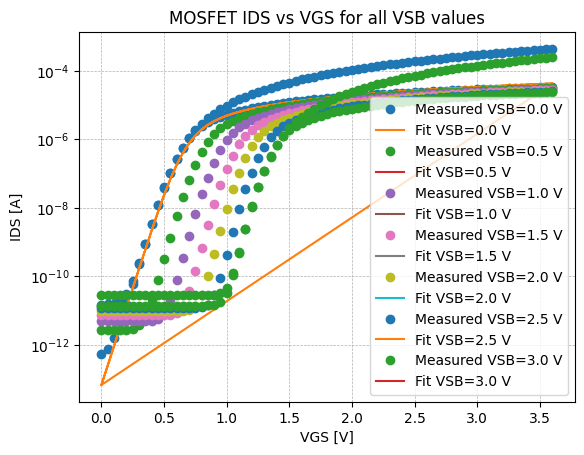

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

UT = 0.02585

class MOSFET_EKV:
    def __init__(self, W=25e-6, L=25e-6, tox=10.5e-9, e_ox=3.45e-11, vds=0.1,
                 vgs_min=0.3, vgs_max=3.5, ids_min=1e-7, ids_max=5e-5,
                 bottom_frac_6=0.6, bottom_frac_3=0.3):
        self.W = W
        self.L = L
        self.tox = tox
        self.e_ox = e_ox
        self.cox = e_ox / tox
        self.vds = vds
        self.vgs_min = vgs_min
        self.vgs_max = vgs_max
        self.ids_min = ids_min
        self.ids_max = ids_max
        self.bottom_frac_6 = bottom_frac_6
        self.bottom_frac_3 = bottom_frac_3
        self.vt_dict = {}
        self.fit_lines = {}
        self.mu_0 = None
        self.theta = None
        self.alpha = None
        self.phi_0 = None
        self.gamma = None
        self.Vfb = None
        self.Vt0 = None
        self.kappa_results = []

    def load_data(self, filename):
        self.data = pd.read_csv(filename, delim_whitespace=True)
        self.data.columns = self.data.columns.str.strip().str.upper()
        return self.data

    def extract_vt(self, vds=None, phi0_sweep=None):
        if vds is not None:
            self.vds = vds
        if phi0_sweep is None:
            phi0_sweep = np.linspace(0.3, 1.5, 100)

        data_vds = self.data[self.data["VDS"] == self.vds]
        self.vt_dict = {}
        self.fit_lines = {}

        for vsb in sorted(data_vds["VSB"].unique()):
            subset = data_vds[data_vds["VSB"] == vsb].sort_values("VGS")
            filtered = subset[
                (subset["IDS"].between(self.ids_min, self.ids_max)) &
                (subset["VGS"].between(self.vgs_min, self.vgs_max))
            ]
            vgs_all = filtered["VGS"].values
            ids_all = filtered["IDS"].values
            n_points = max(2, int(len(ids_all) * self.bottom_frac_6))
            vgs = vgs_all[:n_points]
            ids = ids_all[:n_points]
            slope, intercept, r, _, _ = linregress(vgs, ids)
            vt = -intercept / slope
            self.vt_dict[vsb] = vt
            self.fit_lines[vsb] = (slope, intercept)

        vsb_vals = np.array(sorted(self.vt_dict.keys()))
        vt_vals = np.array([self.vt_dict[v] for v in vsb_vals])
        best_phi0 = None
        best_r2 = -np.inf
        best_fit = None
        for phi0 in phi0_sweep:
            x = np.sqrt(phi0 + vsb_vals)
            slope, intercept, r, _, _ = linregress(x, vt_vals)
            r2 = r**2
            if r2 > best_r2:
                best_r2 = r2
                best_phi0 = phi0
                best_fit = (slope, intercept)
        self.phi_0 = best_phi0
        self.gamma, intercept = best_fit
        self.Vfb = intercept - best_phi0
        self.Vt0 = self.Vfb + self.phi_0 + self.gamma * np.sqrt(self.phi_0)
        return self.phi_0, self.gamma, self.Vfb, self.Vt0

    def extract_mobility(self, vsb=0.0):
        data_copy = self.data[(self.data["VDS"] == self.vds) & (self.data["VSB"] == vsb)].copy()
        data_copy.sort_values("VGS", inplace=True)
        VGS = data_copy["VGS"].values
        IDS = data_copy["IDS"].values
        filter_idx = (VGS > self.Vt0) & (IDS > 1e-8)
        VGS_fit = VGS[filter_idx]
        IDS_fit = IDS[filter_idx]
        n_points = int(len(VGS_fit) * self.bottom_frac_3)
        VGS_low = VGS_fit[:n_points]
        IDS_low = IDS_fit[:n_points]
        slope, intercept, r, _, _ = linregress(VGS_low, IDS_low)
        self.mu_0 = slope / (self.cox * (self.W / self.L) * self.vds)
        if len(VGS_fit) > n_points:
            slope_high, _, _, _, _ = linregress(VGS_fit[-n_points:], IDS_fit[-n_points:])
            self.theta = max(0, (slope - slope_high) / (slope * (VGS_fit[-1] - VGS_fit[0])))
        else:
            self.theta = 0.0

    def fit_mosfet_model(self, vsb=0.0):
        data_copy = self.data[(self.data["VDS"] == self.vds) & (self.data["VSB"] == vsb)].copy()
        data_copy.sort_values("VGS", inplace=True)
        VGS = data_copy["VGS"].values
        IDS = data_copy["IDS"].values
        filter_idx = (VGS > self.Vt0) & (IDS > 1e-8)
        VGS_fit = VGS[filter_idx]
        IDS_fit = IDS[filter_idx]

        def ids_mobility_degradation(VGS, mu0, theta):
            return mu0 * self.cox * (self.W/self.L) * self.vds * (VGS - self.Vt0)/(1 + theta*(VGS - self.Vt0))

        initial_guess = [1e-3, 0.1]
        params, _ = curve_fit(ids_mobility_degradation, VGS_fit, IDS_fit, p0=initial_guess)
        self.mu_0, self.theta = params

    def extract_alpha(self, datafile='mosfet_data1.txt', vsb=0.0):
        data1 = pd.read_csv(datafile, delim_whitespace=True)
        data1.columns = data1.columns.str.strip().str.upper()
        data_vsb = data1[data1["VSB"] == vsb]
        VDS = data_vsb["VDS"].values
        VGS = data_vsb["VGS"].values
        IDS = data_vsb["IDS"].values

        alpha_range = np.linspace(0.05, 5, 200)
        best_alpha = None
        best_r2 = -np.inf

        def mosfet_model(VDS, VGS, alpha):
            VDS_prime = (VGS - self.Vt0) / alpha
            mu_eff = np.where(VGS > self.Vt0, self.mu_0 / (1 + self.theta*(VGS - self.Vt0)), 0)
            ids_linear = (self.W/self.L) * mu_eff * self.cox * ((VGS - self.Vt0) * VDS - (alpha/2)*VDS**2)
            ids_linear = np.where(VDS <= VDS_prime, ids_linear, 0)
            ids_saturation = (self.W/self.L) * mu_eff * self.cox * ((VGS - self.Vt0)**2 / (2*alpha))
            ids_saturation = np.where(VDS > VDS_prime, ids_saturation, 0)
            return ids_linear + ids_saturation

        for a in alpha_range:
            IDS_model = mosfet_model(VDS, VGS, a)
            SS_res = np.sum((IDS - IDS_model)**2)
            SS_tot = np.sum((IDS - np.mean(IDS))**2)
            r2 = 1 - SS_res/SS_tot
            if r2 > best_r2:
                best_r2 = r2
                best_alpha = a
        self.alpha = best_alpha

    def extract_kappa_I0(self, window_size=7):
        if not hasattr(self, 'data'):
            raise ValueError("Data not loaded. Run load_data() first.")

        self.kappa_results = []

        for vsb_val in sorted(self.data["VSB"].unique()):
            subset = self.data[self.data["VSB"] == vsb_val].sort_values("VGS")
            VGS = subset["VGS"].values
            IDS = subset["IDS"].values
            ln_IDS = np.log(IDS)

            if len(VGS) <= window_size:
                continue

            best_r2 = -np.inf
            best_indices = None
            for i in range(len(VGS) - window_size):
                x_seg = VGS[i:i + window_size]
                y_seg = ln_IDS[i:i + window_size]
                slope, intercept, r_value, _, _ = linregress(x_seg, y_seg)
                if r_value**2 > best_r2:
                    best_r2 = r_value**2
                    best_indices = (i, i + window_size)

            i_start, i_end = best_indices
            x_lin = VGS[i_start:i_end]
            y_lin = ln_IDS[i_start:i_end]

            slope, intercept, r_value, _, _ = linregress(x_lin, y_lin)
            kappa_fit = slope * UT
            I0_fit = np.exp(intercept)

            self.kappa_results.append({
                "VSB": vsb_val,
                "I0": I0_fit,
                "kappa": kappa_fit,
            })
        print(f"VSB = {vsb_val} V → kappa = {kappa_fit}, I0 = {I0_fit}")
        return self.kappa_results

    def plot_fit_all_vsb(self):
        fits_dict = {}
        vsb_values = sorted(self.data["VSB"].unique())
        for vsb_val in vsb_values:
            subset = self.data[self.data["VSB"] == vsb_val]
            VGS_meas = subset["VGS"].values
            IDS_meas = subset["IDS"].values
            kappa_map = {res["VSB"]: res for res in self.kappa_results}
            result = kappa_map.get(vsb_val)
            kappa = result["kappa"]
            I0 = result["I0"]
            VDS = self.vds
            VGS_fit_smooth = np.linspace(min(VGS_meas), max(VGS_meas), 200)

            IDS_fit_smooth = (self.W/self.L) * ((self.mu_0*self.cox)/kappa) * 2 * UT**2 * (
                np.log(1 + np.exp((kappa*(VGS_meas - self.Vt0) - vsb_val)/(2*UT)))**2 -
                np.log(1 + np.exp((kappa*(VGS_meas - self.Vt0) - (VDS - vsb_val))/(2*UT)))**2
            )
            fits_dict[vsb_val] = {
                "VGS_meas": VGS_meas,
                "IDS_meas": IDS_meas,
                "VGS_fit_smooth": VGS_fit_smooth,
                "IDS_fit_smooth": IDS_fit_smooth
            }
            plt.semilogy(VGS_meas, IDS_meas, 'o', label=f"Measured VSB={vsb_val} V")
            plt.semilogy(VGS_meas, IDS_fit_smooth, '-', label=f"Fit VSB={vsb_val} V")


        plt.xlabel("VGS [V]")
        plt.ylabel("IDS [A]")
        plt.title("MOSFET IDS vs VGS for all VSB values")
        plt.legend()
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()



mosfet = MOSFET_EKV()
mosfet.load_data('mosfet_data2.txt')
mosfet.extract_vt()
mosfet.extract_mobility()
mosfet.fit_mosfet_model()
mosfet.extract_alpha('mosfet_data1.txt')
mosfet.extract_kappa_I0()
mosfet.plot_fit_all_vsb()


